## RL simulation analyses

In [1]:
import sys
import os
base_path = ".."
sys.path.insert(0, base_path)
os.chdir(base_path)

from scipy.stats import t
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

%matplotlib inline

In [2]:
parameters = {
    'snr': [0.5, 1, 2, 3, 5],
    'n_bins': [10],
    'kernel_size': [20],
    'kernel_sigma': [0.5, 1.0, 2.0, 3.0, 4.0],
    'learning_rate': [0.05, 0.1, 0.3, 0.4, 0.8, 0.9],
    'temperature': [0.2],
    'min_temperature': [1e-5],
    'max_temperature': [1.0],
    'reduce_temperature': [False],
    'decay_rate': [0.001]
}

# load data;
data = pd.read_pickle("./data/hyperparameter_search.pkl")
print("Unique combinations of parameters", data.shape[0])

Unique combinations of parameters 1500000


## Summarize parameter search

### Reward given SNR and Smoothing Sigma

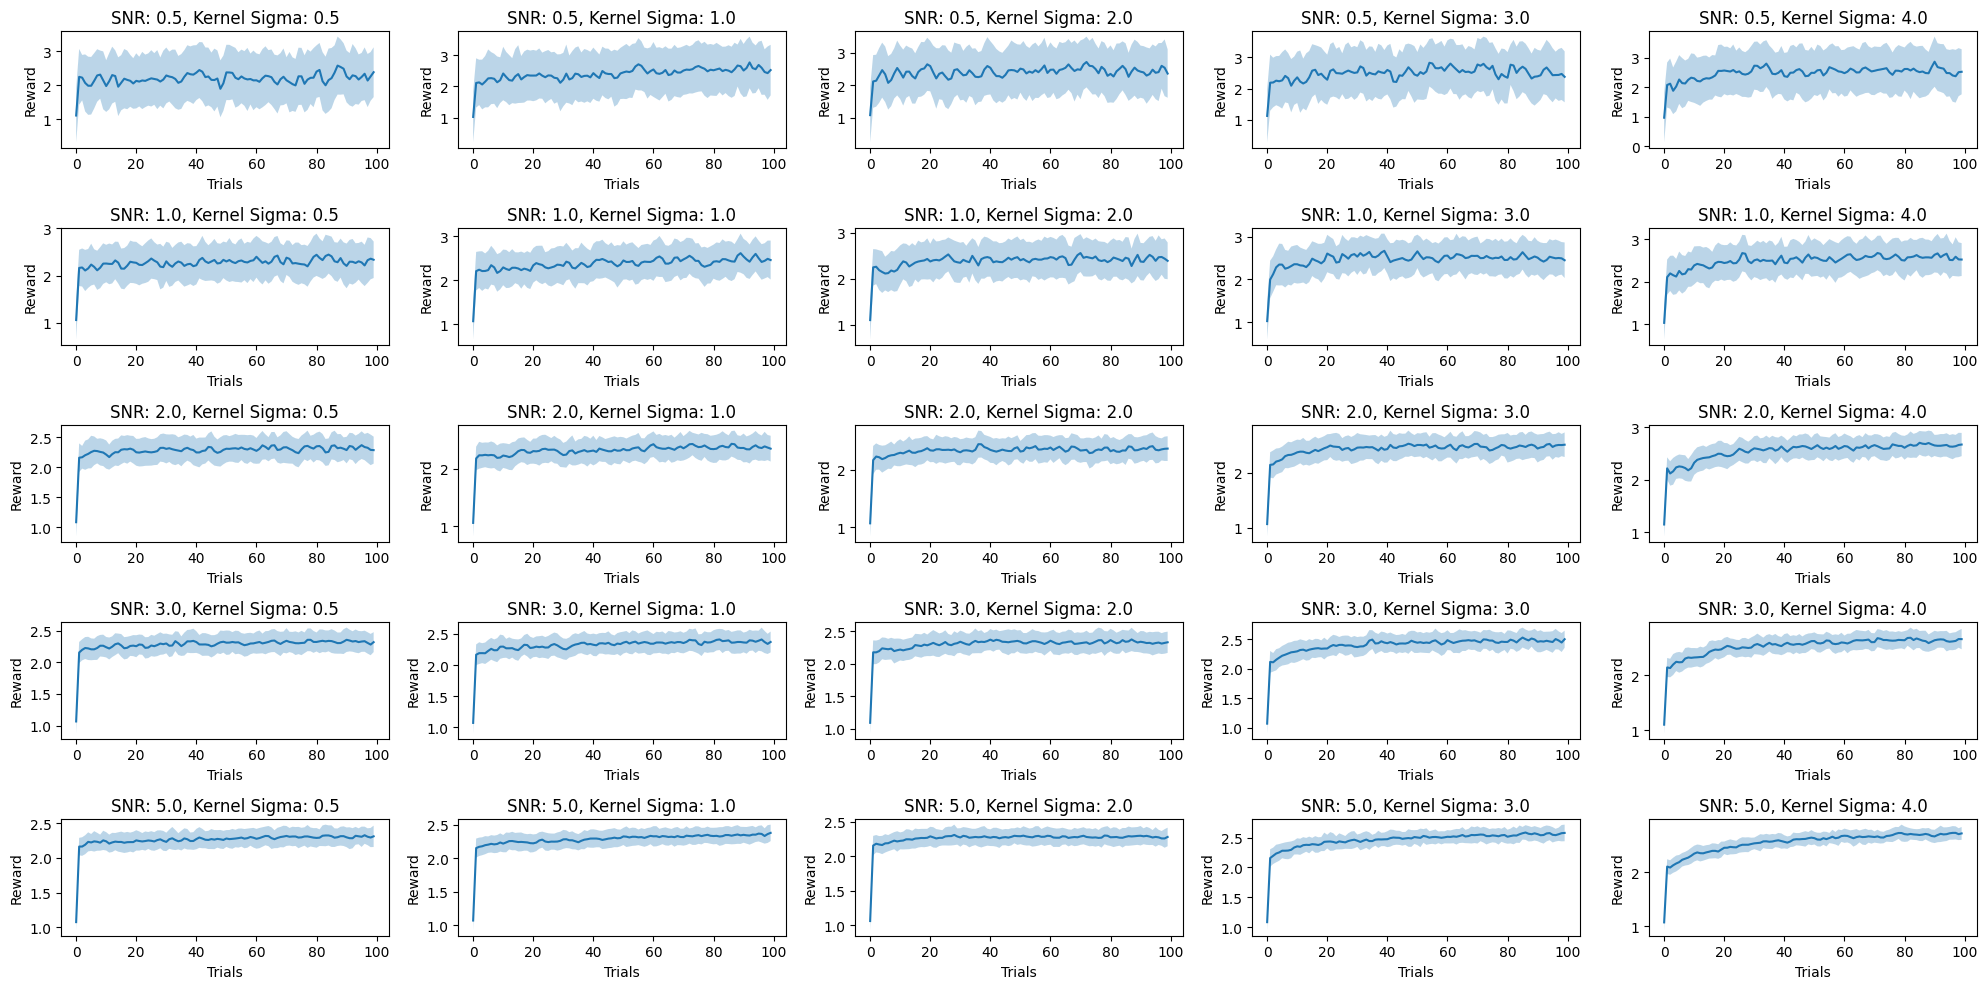

In [3]:
# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_learning_rate_values = data["learning_rate"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

# Generate all combinations of snr, kernel_sigma, lr, and temp
lr_temp_combinations = list(itertools.product(
    unique_learning_rate_values,
    unique_temperature_values
))

num_rows = len(unique_snr_values)
num_cols = len(unique_kernel_sigma_values)
row_idx = 0
col_idx = 0

n_epochs = 100
epoch_length = list(range(0, n_epochs))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# loop through all combinations;
for idx, (snr, kernel_sigma) in enumerate(snr_kernel_combinations):
    # vars to save trials data;
    trial_summary = []
    trial_ci = []
    trial_lr_summary = []

    # get data for current parameters;
    sub_data = data[(data['snr'] == snr) & (data['kernel_sigma'] == kernel_sigma)]

    # generate subplot data;
    for epoch in epoch_length:
        trial_data = sub_data[sub_data["epochs"] == epoch]
        trial_summary.append(np.mean(trial_data["reward"]))
        trial_lr_summary.append(np.mean(trial_data["learning_rate"]))

        # get only data with best learning_rate;
        best_learning_rate = trial_data.loc[trial_data["reward"].idxmax(), ["learning_rate"]]
        trial_data = trial_data[trial_data["learning_rate"] == best_learning_rate.iloc[0]]

        # calculate the 95% confidence interval for reward;
        confidence_interval = t.interval(0.95, len(trial_data["reward"]) - 1,
                                         loc=np.mean(trial_data["reward"]),
                                         scale=np.std(trial_data["reward"]) / np.sqrt(len(trial_data["reward"])))
        trial_ci.append((confidence_interval[1] - confidence_interval[0]) / 2)

    # apply median smoothing to trial_summary using a rolling window;
    window_size = 2
    smoothed_summary = np.convolve(trial_summary, np.ones(window_size)/window_size, mode='same')

    # Fig1. Plot performance with the smoothed line; 
    axs[row_idx, col_idx].plot(epoch_length, smoothed_summary, label='Smoothed Mean Reward')

    # Fill the 95% confidence interval
    lower_bound = np.array(smoothed_summary) - np.array(trial_ci)
    upper_bound = np.array(smoothed_summary) + np.array(trial_ci)
    axs[row_idx, col_idx].fill_between(epoch_length, lower_bound, upper_bound, alpha=0.3, label='95% Confidence Interval')

    axs[row_idx, col_idx].set_xlabel("Trials")
    axs[row_idx, col_idx].set_ylabel("Reward")
    axs[row_idx, col_idx].set_title(f"SNR: {snr}, Kernel Sigma: {kernel_sigma}")
    # axs[row_idx, col_idx].legend()

    # correctly index subplots
    col_idx += 1
    if col_idx == num_cols:
        row_idx += 1
        col_idx = 0

# adjust layout;
plt.tight_layout()
plt.show()

### Values for optimal Q-value (max contrast, 0.7 frequency) given SNR and Smoothing Sigma

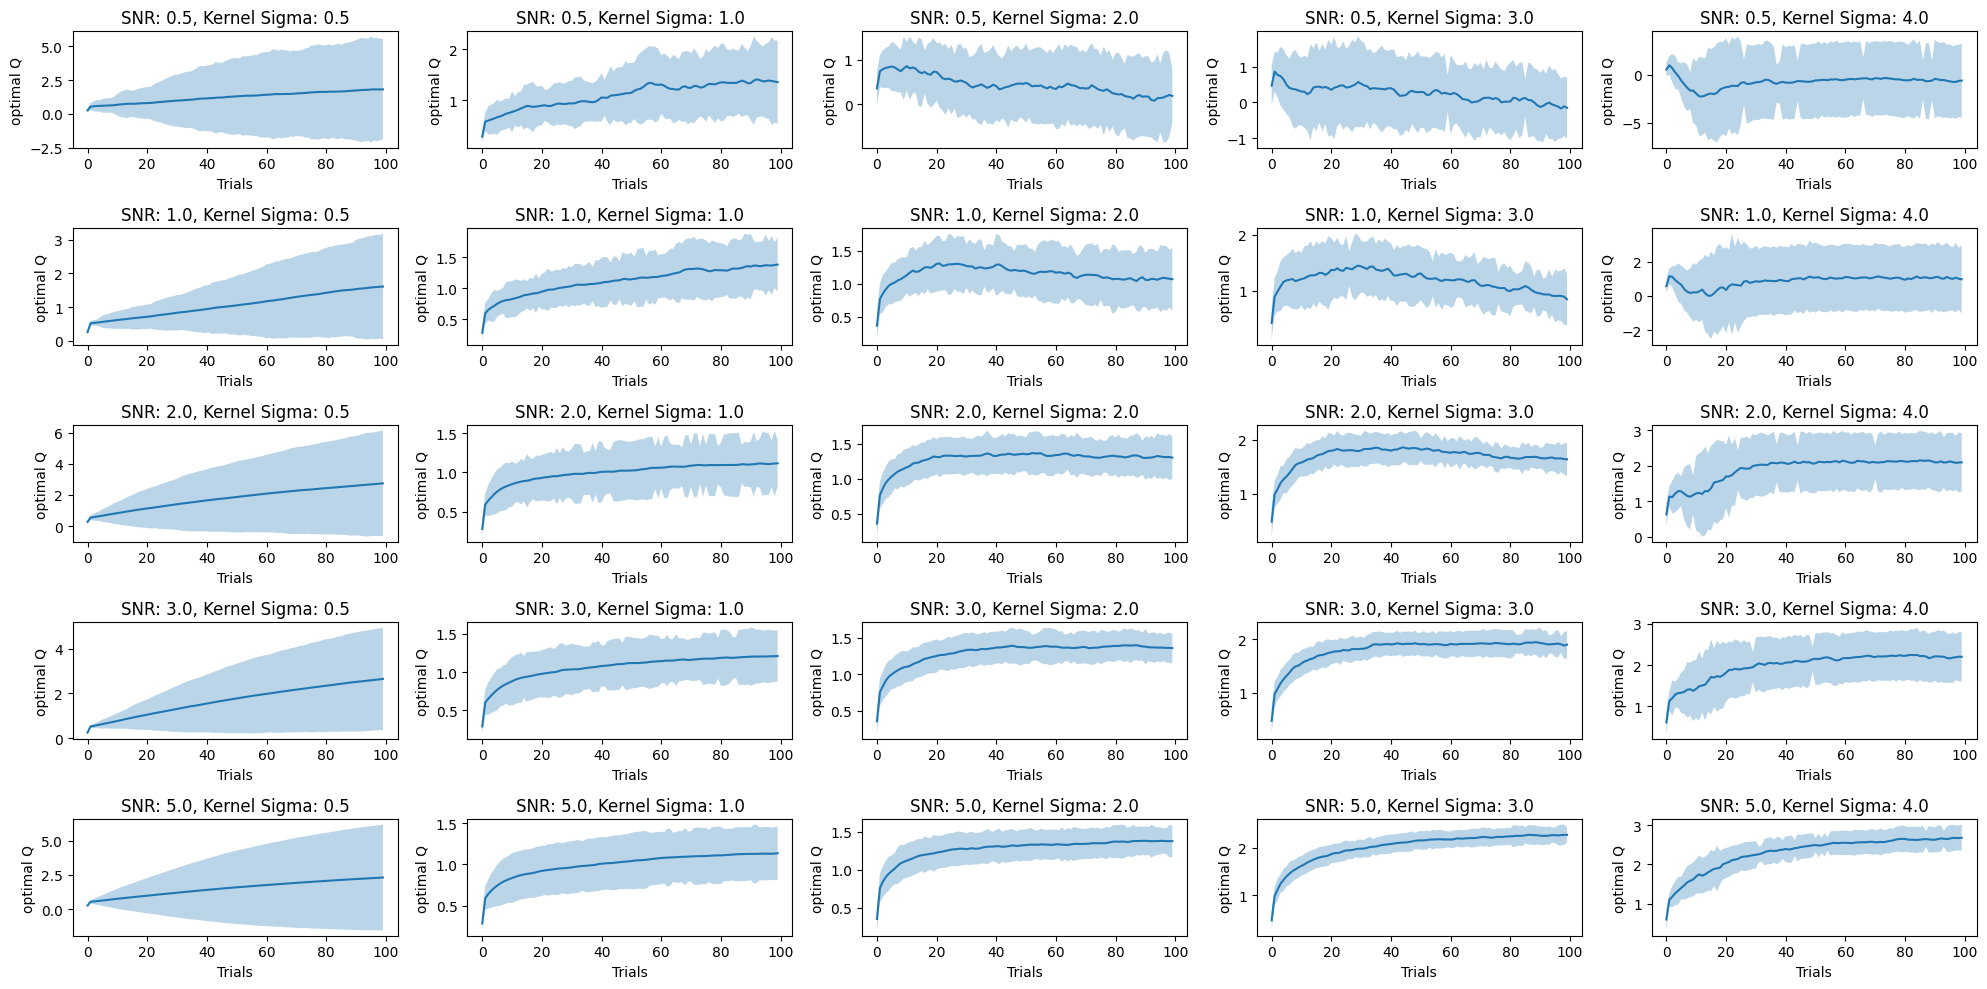

In [4]:
# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_learning_rate_values = data["learning_rate"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

# Generate all combinations of snr, kernel_sigma, lr, and temp
lr_temp_combinations = list(itertools.product(
    unique_learning_rate_values,
    unique_temperature_values
))

num_rows = len(unique_snr_values)
num_cols = len(unique_kernel_sigma_values)
row_idx = 0
col_idx = 0

n_epochs = 100
epoch_length = list(range(0, n_epochs))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# loop through all combinations;
for idx, (snr, kernel_sigma) in enumerate(snr_kernel_combinations):
    # vars to save trials data;
    trial_summary = []
    trial_ci = []
    trial_best_lr = []
    trial_best_temp = []

    # get data for current parameters;
    sub_data = data[(data['snr'] == snr) & (data['kernel_sigma'] == kernel_sigma)]

    # generate subplot data;
    for epoch in epoch_length:
        trial_data = sub_data[sub_data["epochs"] == epoch]
        trial_summary.append(np.mean(trial_data["optimum"]))

        # get only data with best learning_rate;
        best_learning_rate = trial_data.loc[trial_data["optimum"].idxmax(), ["learning_rate"]]
        trial_data = trial_data[trial_data["learning_rate"] == best_learning_rate.iloc[0]]

        # calculate the 95% confidence interval;
        confidence_interval = t.interval(0.95, len(trial_data["optimum"]) - 1,
                                         loc=np.mean(trial_data["optimum"]),
                                         scale=np.std(trial_data["optimum"]) / np.sqrt(len(trial_data["optimum"])))
        trial_ci.append((confidence_interval[1] - confidence_interval[0]) / 2)

    # Apply median smoothing to trial_summary using a rolling window
    window_size = 2
    smoothed_summary = np.convolve(trial_summary, np.ones(window_size)/window_size, mode='same')

    # Plot the smoothed line
    axs[row_idx, col_idx].plot(epoch_length, smoothed_summary, label='Smoothed Mean optimal Q-value')

    # Fill the 95% confidence interval
    lower_bound = np.array(smoothed_summary) - np.array(trial_ci)
    upper_bound = np.array(smoothed_summary) + np.array(trial_ci)
    axs[row_idx, col_idx].fill_between(epoch_length, lower_bound, upper_bound, alpha=0.3, label='95% Confidence Interval')

    axs[row_idx, col_idx].set_xlabel("Trials")
    axs[row_idx, col_idx].set_ylabel("optimal Q")
    axs[row_idx, col_idx].set_title(f"SNR: {snr}, Kernel Sigma: {kernel_sigma}")
    # axs[row_idx, col_idx].legend()

    # correctly index subplots
    col_idx += 1
    if col_idx == num_cols:
        row_idx += 1
        col_idx = 0

# adjust layout;
plt.tight_layout()
plt.show()

### Check for possible ideal learning rate at each trial

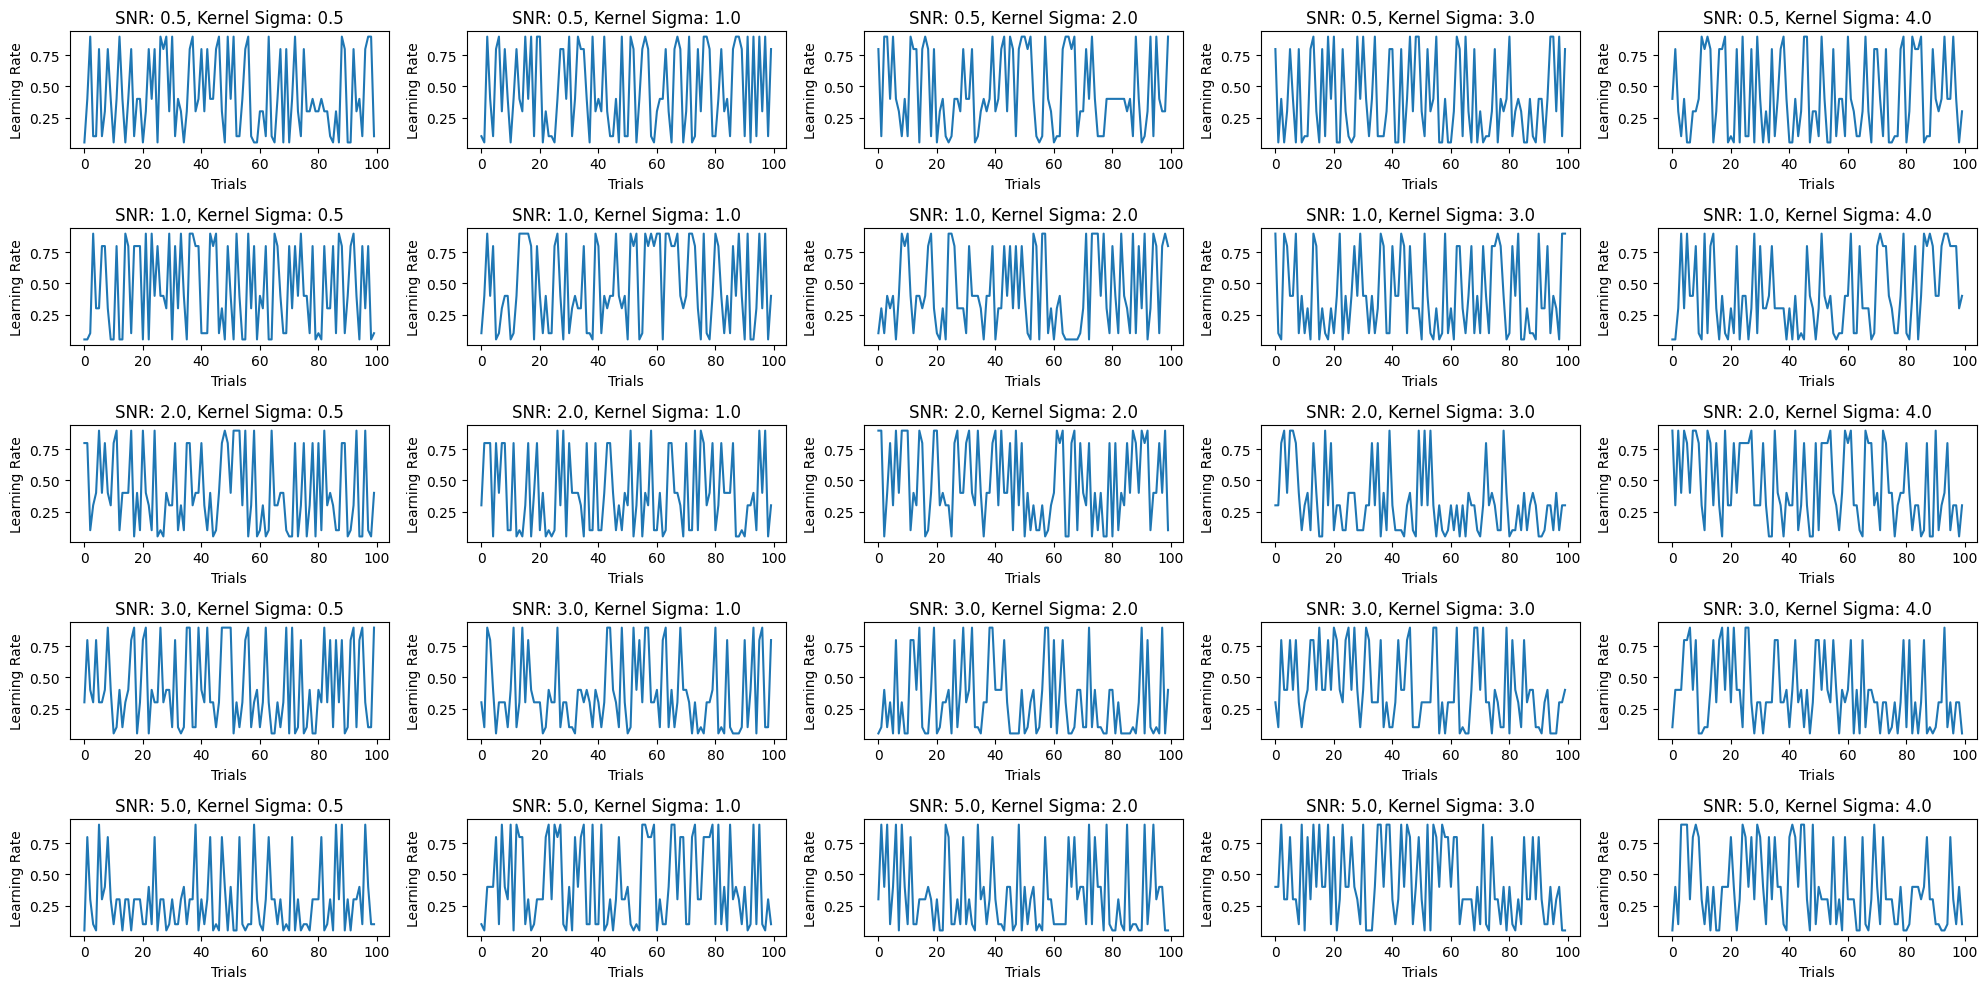

In [5]:
# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_learning_rate_values = data["learning_rate"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

# Generate all combinations of snr, kernel_sigma, lr, and temp
lr_temp_combinations = list(itertools.product(
    unique_learning_rate_values,
    unique_temperature_values
))

num_rows = len(unique_snr_values)
num_cols = len(unique_kernel_sigma_values)
row_idx = 0
col_idx = 0

n_epochs = 100
epoch_length = list(range(0, n_epochs))
fig2, axs2 = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# loop through all combinations;
for idx, (snr, kernel_sigma) in enumerate(snr_kernel_combinations):
    # vars to save trials data;
    trial_summary = []
    trial_best_lr = []
    trial_lr_summary = []

    # get data for current parameters;
    sub_data = data[(data['snr'] == snr) & (data['kernel_sigma'] == kernel_sigma)]

    # generate subplot data;
    for epoch in epoch_length:
        trial_data = sub_data[sub_data["epochs"] == epoch]
        trial_summary.append(np.mean(trial_data["reward"]))
        trial_lr_summary.append(np.mean(trial_data["learning_rate"]))

        # get only data with best learning_rate;
        best_learning_rate = trial_data.loc[trial_data["reward"].idxmax(), ["learning_rate"]]
        trial_data = trial_data[trial_data["learning_rate"] == best_learning_rate.iloc[0]]
        trial_best_lr.append(best_learning_rate)

    # apply median smoothing to trial_summary using a rolling window;
    window_size = 2
    smoothed_summary = np.convolve(trial_summary, np.ones(window_size)/window_size, mode='same')

    # Fig2. Plot learning rate with the smoothed line; 
    axs2[row_idx, col_idx].plot(epoch_length, trial_best_lr, label='Best LR')

    axs2[row_idx, col_idx].set_xlabel("Trials")
    axs2[row_idx, col_idx].set_ylabel("Learning Rate")
    axs2[row_idx, col_idx].set_title(f"SNR: {snr}, Kernel Sigma: {kernel_sigma}")

    # correctly index subplots
    col_idx += 1
    if col_idx == num_cols:
        row_idx += 1
        col_idx = 0

# adjust layout;
plt.tight_layout()
plt.show()

### Check for possible ideal temperature at each trial

**NOTE**: Temperature is fixed during simulations. The cell below can still be useful in case the hyperparameter search is done again with multiple values for the temperature 

In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

num_rows = len(unique_snr_values)
num_cols = len(unique_kernel_sigma_values)
row_idx = 0
col_idx = 0

n_epochs = 100
epoch_length = list(range(0, n_epochs))
fig2, axs2 = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# loop through all combinations;
for idx, (snr, kernel_sigma) in enumerate(snr_kernel_combinations):
    # vars to save trials data;
    trial_summary = []
    trial_best_temp = []
    trial_temp_summary = []

    # get data for current parameters;
    sub_data = data[(data['snr'] == snr) & (data['kernel_sigma'] == kernel_sigma)]

    # generate subplot data;
    for epoch in epoch_length:
        trial_data = sub_data[sub_data["epochs"] == epoch]
        trial_summary.append(np.mean(trial_data["reward"]))
        trial_temp_summary.append(np.mean(trial_data["temperature"]))

        # get only data with best temperature;
        best_temperature = trial_data.loc[trial_data["reward"].idxmax(), ["temperature"]]
        trial_data = trial_data[trial_data["temperature"] == best_temperature.iloc[0]]
        trial_best_temp.append(best_temperature)

    # apply median smoothing to trial_summary using a rolling window;
    window_size = 2
    smoothed_summary = np.convolve(trial_summary, np.ones(window_size)/window_size, mode='same')

    # Fig2. Plot temperature with the smoothed line; 
    axs2[row_idx, col_idx].plot(epoch_length, trial_best_temp, label='Best Temp')

    axs2[row_idx, col_idx].set_xlabel("Trials")
    axs2[row_idx, col_idx].set_ylabel("Temperature")
    axs2[row_idx, col_idx].set_title(f"SNR: {snr}, Kernel Sigma: {kernel_sigma}")

    # correctly index subplots
    col_idx += 1
    if col_idx == num_cols:
        row_idx += 1
        col_idx = 0

# adjust layout;
plt.tight_layout()
plt.show()
